In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [5]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size, cx):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = 1.0  # the interaction parameter corresponds to Z
    v = cx  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="y",)

def findMin(ansatz, reps, cx):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i, cx)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [9]:
# define maximum size of system
n = 11
#define number of repetitions
r = 5
# Number of x-samples we have
s = 41

samples = [round(-2.0 + (4 * j/(s-1)), 5) for j in range(s)]
print(samples)

[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


In [10]:
# Find True Groundstates of Model
trueGroundStates = np.full([s,n], 0.0)
trueTimes = np.full([s,n], 0.0)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    for j in range(1, n):
        t1_start = time.time()
        trueGroundStates[i][j] = findGroundState(makeLatticeIsing(j, cx))
        trueTimes[i][j] =  time.time() - t1_start
        print(f"{j:>10}: {round(trueGroundStates[i][j],3):<7} time: {round(trueTimes[i][j],3)}")

X = -2.0:
         1: -2.0    time: 0.001
         2: -4.123  time: 0.004
         3: -6.292  time: 0.007
         4: -8.543  time: 0.009
         5: -10.62  time: 0.012
         6: -12.769 time: 0.02
         7: -14.886 time: 0.027
         8: -17.018 time: 0.033
         9: -19.143 time: 0.064
        10: -21.271 time: 0.311
X = -1.9:
         1: -1.9    time: 0.001
         2: -3.929  time: 0.003
         3: -6.003  time: 0.005
         4: -8.176  time: 0.007
         5: -10.151 time: 0.01
         6: -12.213 time: 0.011
         7: -14.234 time: 0.016
         8: -16.274 time: 0.025
         9: -18.305 time: 0.069
        10: -20.341 time: 0.286
X = -1.8:
         1: -1.8    time: 0.001
         2: -3.736  time: 0.003
         3: -5.715  time: 0.006
         4: -7.813  time: 0.008
         5: -9.686  time: 0.01
         6: -11.662 time: 0.013
         7: -13.587 time: 0.017
         8: -15.537 time: 0.026
         9: -17.475 time: 0.065
        10: -19.419 time: 0.286
X = -1.7:
   

         9: -8.572  time: 0.17
        10: -10.636 time: 0.513
X = 0.6:
         1: -0.6    time: 0.001
         2: -1.562  time: 0.004
         3: -2.4    time: 0.008
         4: -4.403  time: 0.01
         5: -4.643  time: 0.011
         6: -6.563  time: 0.014
         7: -6.84   time: 0.023
         8: -8.741  time: 0.042
         9: -9.028  time: 0.112
        10: -10.923 time: 0.528
X = 0.7:
         1: -0.7    time: 0.001
         2: -1.72   time: 0.003
         3: -2.66   time: 0.007
         4: -4.564  time: 0.008
         5: -4.995  time: 0.011
         6: -6.783  time: 0.018
         7: -7.273  time: 0.027
         8: -9.024  time: 0.038
         9: -9.535  time: 0.102
        10: -11.272 time: 0.475
X = 0.8:
         1: -0.8    time: 0.001
         2: -1.887  time: 0.003
         3: -2.924  time: 0.007
         4: -4.756  time: 0.008
         5: -5.367  time: 0.012
         6: -7.049  time: 0.017
         7: -7.74   time: 0.029
         8: -9.365  time: 0.04
         9: -10.

In [12]:
results = [None] * s
groundStates = [None] * s
times = [None] * s
print(groundStates)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
ansatz = makeAnsatz(reps = 1)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    results[i], groundStates[i], times[i] = findMin(ansatz, r, cx)

X = -2.0:
Minimum    1: 0.0     time: 0.13
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.11
Minimum    2: -2.562  time: 0.09
Processed  2          time: 0.11
Processed  2          time: 0.14
Minimum    2: -2.562  time: 0.07
Minimum    3: -4.327  time: 0.29
Processed  3          time: 0.27
Processed  3          time: 0.39
Processed  3          time: 0.17
Processed  3          time: 0.22
Minimum    4: -6.472  time: 0.41
Processed  4          time: 0.29
Processed  4          time: 0.28
Processed  4          time: 0.31
Processed  4          time: 0.41
Minimum    5: -7.31   time: 0.48
Minimum    5: -7.31   time: 0.74
Processed  5          time: 0.62
Minimum    5: -7.31   time: 0.4
Processed  5          time: 0.68
Minimum    6: -9.527  time: 0.8
Processed  6          time: 0.85
Minimum    6: -9.708  time: 0.89
Processed  6          time: 0.82
Processed  6          time: 1.13
Mi

Processed 10          time: 5.09
Processed 10          time: 4.94
X = -1.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.081  time: 0.08
Processed  2          time: 0.07
Processed  2          time: 0.1
Processed  2          time: 0.05
Processed  2          time: 0.06
Minimum    3: -3.391  time: 0.16
Minimum    3: -3.391  time: 0.19
Processed  3          time: 0.24
Minimum    3: -3.391  time: 0.24
Processed  3          time: 0.37
Minimum    4: -3.0    time: 0.29
Minimum    4: -3.0    time: 0.23
Minimum    4: -5.606  time: 0.28
Minimum    4: -5.606  time: 0.27
Processed  4          time: 0.27
Minimum    5: -6.008  time: 0.53
Processed  5          time: 0.52
Processed  5          time: 0.58
Processed  5          time: 0.55
Processed  5          time: 0.44
Minimum    6: -8.408  time: 0.63
Minimum    6: -8.408  time: 0.62
Minimum    6: -8.408  time: 1.03
P

Processed 10          time: 7.55
Processed 10          time: 9.62
Processed 10          time: 7.95
Minimum   10: -12.433 time: 5.23
X = -1.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.618  time: 0.2
Minimum    2: -1.618  time: 0.09
Processed  2          time: 0.04
Processed  2          time: 0.11
Processed  2          time: 0.07
Minimum    3: -2.484  time: 0.23
Processed  3          time: 0.19
Minimum    3: -2.484  time: 0.33
Processed  3          time: 0.17
Processed  3          time: 0.26
Minimum    4: -4.828  time: 0.22
Processed  4          time: 0.3
Processed  4          time: 0.33
Processed  4          time: 0.47
Minimum    4: -4.828  time: 0.3
Minimum    5: -4.798  time: 0.59
Processed  5          time: 0.66
Processed  5          time: 0.73
Processed  5          time: 0.72
Minimum    5: -4.798  time: 0.62
Minimum    6: -7.243  time: 0.5
Proc

Processed  9          time: 4.01
Minimum   10: -7.917  time: 12.48
Minimum   10: -7.917  time: 8.49
Processed 10          time: 10.62
Minimum   10: -10.831 time: 6.75
Processed 10          time: 8.93
X = -0.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.207  time: 0.14
Minimum    2: -1.207  time: 0.15
Processed  2          time: 0.05
Processed  2          time: 0.09
Processed  2          time: 0.05
Minimum    3: -1.64   time: 0.28
Minimum    3: -1.64   time: 0.41
Processed  3          time: 0.35
Minimum    3: -1.64   time: 0.42
Processed  3          time: 0.44
Minimum    4: -4.236  time: 0.75
Processed  4          time: 0.6
Processed  4          time: 0.33
Processed  4          time: 0.56
Processed  4          time: 0.54
Minimum    5: -3.74   time: 1.03
Minimum    5: -3.74   time: 1.05
Processed  5          time: 0.68
Processed  5          time: 0.52

Processed  9          time: 5.13
Minimum    9: -7.12   time: 7.66
Processed  9          time: 6.68
Processed  9          time: 5.9
Minimum   10: -6.22   time: 11.42
Minimum   10: -6.22   time: 17.58
Minimum   10: -10.025 time: 10.14
Minimum   10: -10.025 time: 10.95
Processed 10          time: 13.12
X = 0.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.0    time: 0.07
Processed  2          time: 0.09
Processed  2          time: 0.03
Processed  2          time: 0.04
Processed  2          time: 0.03
Minimum    3: -1.0    time: 0.13
Minimum    3: -1.0    time: 0.1
Processed  3          time: 0.11
Processed  3          time: 0.11
Minimum    3: -1.0    time: 0.08
Minimum    4: -4.0    time: 0.15
Processed  4          time: 0.2
Processed  4          time: 0.2
Minimum    4: -4.0    time: 0.18
Processed  4          time: 0.15
Minimum    5: -3.0    time: 0.21


Processed  8          time: 2.0
Minimum    9: -7.712  time: 4.48
Processed  9          time: 4.29
Processed  9          time: 4.51
Processed  9          time: 4.27
Processed  9          time: 2.82
Minimum   10: -7.123  time: 11.28
Processed 10          time: 12.74
Processed 10          time: 11.35
Processed 10          time: 9.56
Processed 10          time: 8.27
X = 0.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.207  time: 0.07
Processed  2          time: 0.07
Minimum    2: -1.207  time: 0.08
Minimum    2: -1.207  time: 0.06
Processed  2          time: 0.07
Minimum    3: -1.64   time: 0.27
Minimum    3: -1.64   time: 0.24
Processed  3          time: 0.32
Processed  3          time: 0.26
Processed  3          time: 0.28
Minimum    4: -4.236  time: 0.38
Minimum    4: -4.236  time: 0.33
Processed  4          time: 0.52
Processed  4          time: 0.28

Processed  8          time: 1.5
Processed  8          time: 1.77
Processed  8          time: 1.82
Minimum    9: -9.256  time: 2.2
Minimum    9: -9.263  time: 3.07
Processed  9          time: 3.85
Processed  9          time: 3.35
Processed  9          time: 2.56
Minimum   10: -9.094  time: 8.94
Minimum   10: -11.727 time: 5.4
Processed 10          time: 7.46
Processed 10          time: 8.49
Processed 10          time: 4.13
X = 1.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -1.618  time: 0.07
Processed  2          time: 0.09
Minimum    2: -1.618  time: 0.05
Processed  2          time: 0.07
Processed  2          time: 0.07
Minimum    3: -2.484  time: 0.22
Minimum    3: -2.484  time: 0.38
Minimum    3: -2.484  time: 0.35
Processed  3          time: 0.4
Minimum    3: -2.484  time: 0.25
Minimum    4: -4.828  time: 0.37
Processed  4          time: 0.37
Proce

Minimum    8: -10.882 time: 1.34
Processed  8          time: 1.3
Processed  8          time: 1.42
Processed  8          time: 1.12
Minimum    8: -10.882 time: 1.16
Minimum    9: -11.203 time: 2.44
Processed  9          time: 2.48
Processed  9          time: 3.45
Processed  9          time: 3.01
Processed  9          time: 2.96
Minimum   10: -13.602 time: 5.04
Processed 10          time: 5.5
Processed 10          time: 4.92
Minimum   10: -13.602 time: 5.16
Processed 10          time: 6.79
X = 1.5:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.081  time: 0.07
Minimum    2: -2.081  time: 0.07
Processed  2          time: 0.09
Processed  2          time: 0.06
Processed  2          time: 0.05
Minimum    3: -3.391  time: 0.14
Minimum    3: -3.391  time: 0.28
Minimum    3: -3.391  time: 0.19
Processed  3          time: 0.17
Processed  3          time: 0.2
Mini

Processed  7          time: 1.84
Minimum    7: -10.203 time: 0.94
Minimum    8: -10.648 time: 1.32
Minimum    8: -11.182 time: 1.97
Processed  8          time: 1.19
Processed  8          time: 1.25
Minimum    8: -12.588 time: 1.1
Minimum    9: -13.349 time: 2.33
Processed  9          time: 2.28
Minimum    9: -13.349 time: 2.42
Processed  9          time: 2.37
Processed  9          time: 1.96
Minimum   10: -14.017 time: 5.55
Minimum   10: -14.088 time: 4.88
Minimum   10: -14.143 time: 4.07
Minimum   10: -14.341 time: 4.52
Processed 10          time: 5.04
X = 2.0:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.05
Minimum    2: -2.562  time: 0.09
Minimum    2: -2.562  time: 0.1
Processed  2          time: 0.05
Processed  2          time: 0.06
Minimum    3: -4.327  time: 0.25
Processed  3          time: 0.15
Minimum    3: -4.327  time: 0.18
Pro

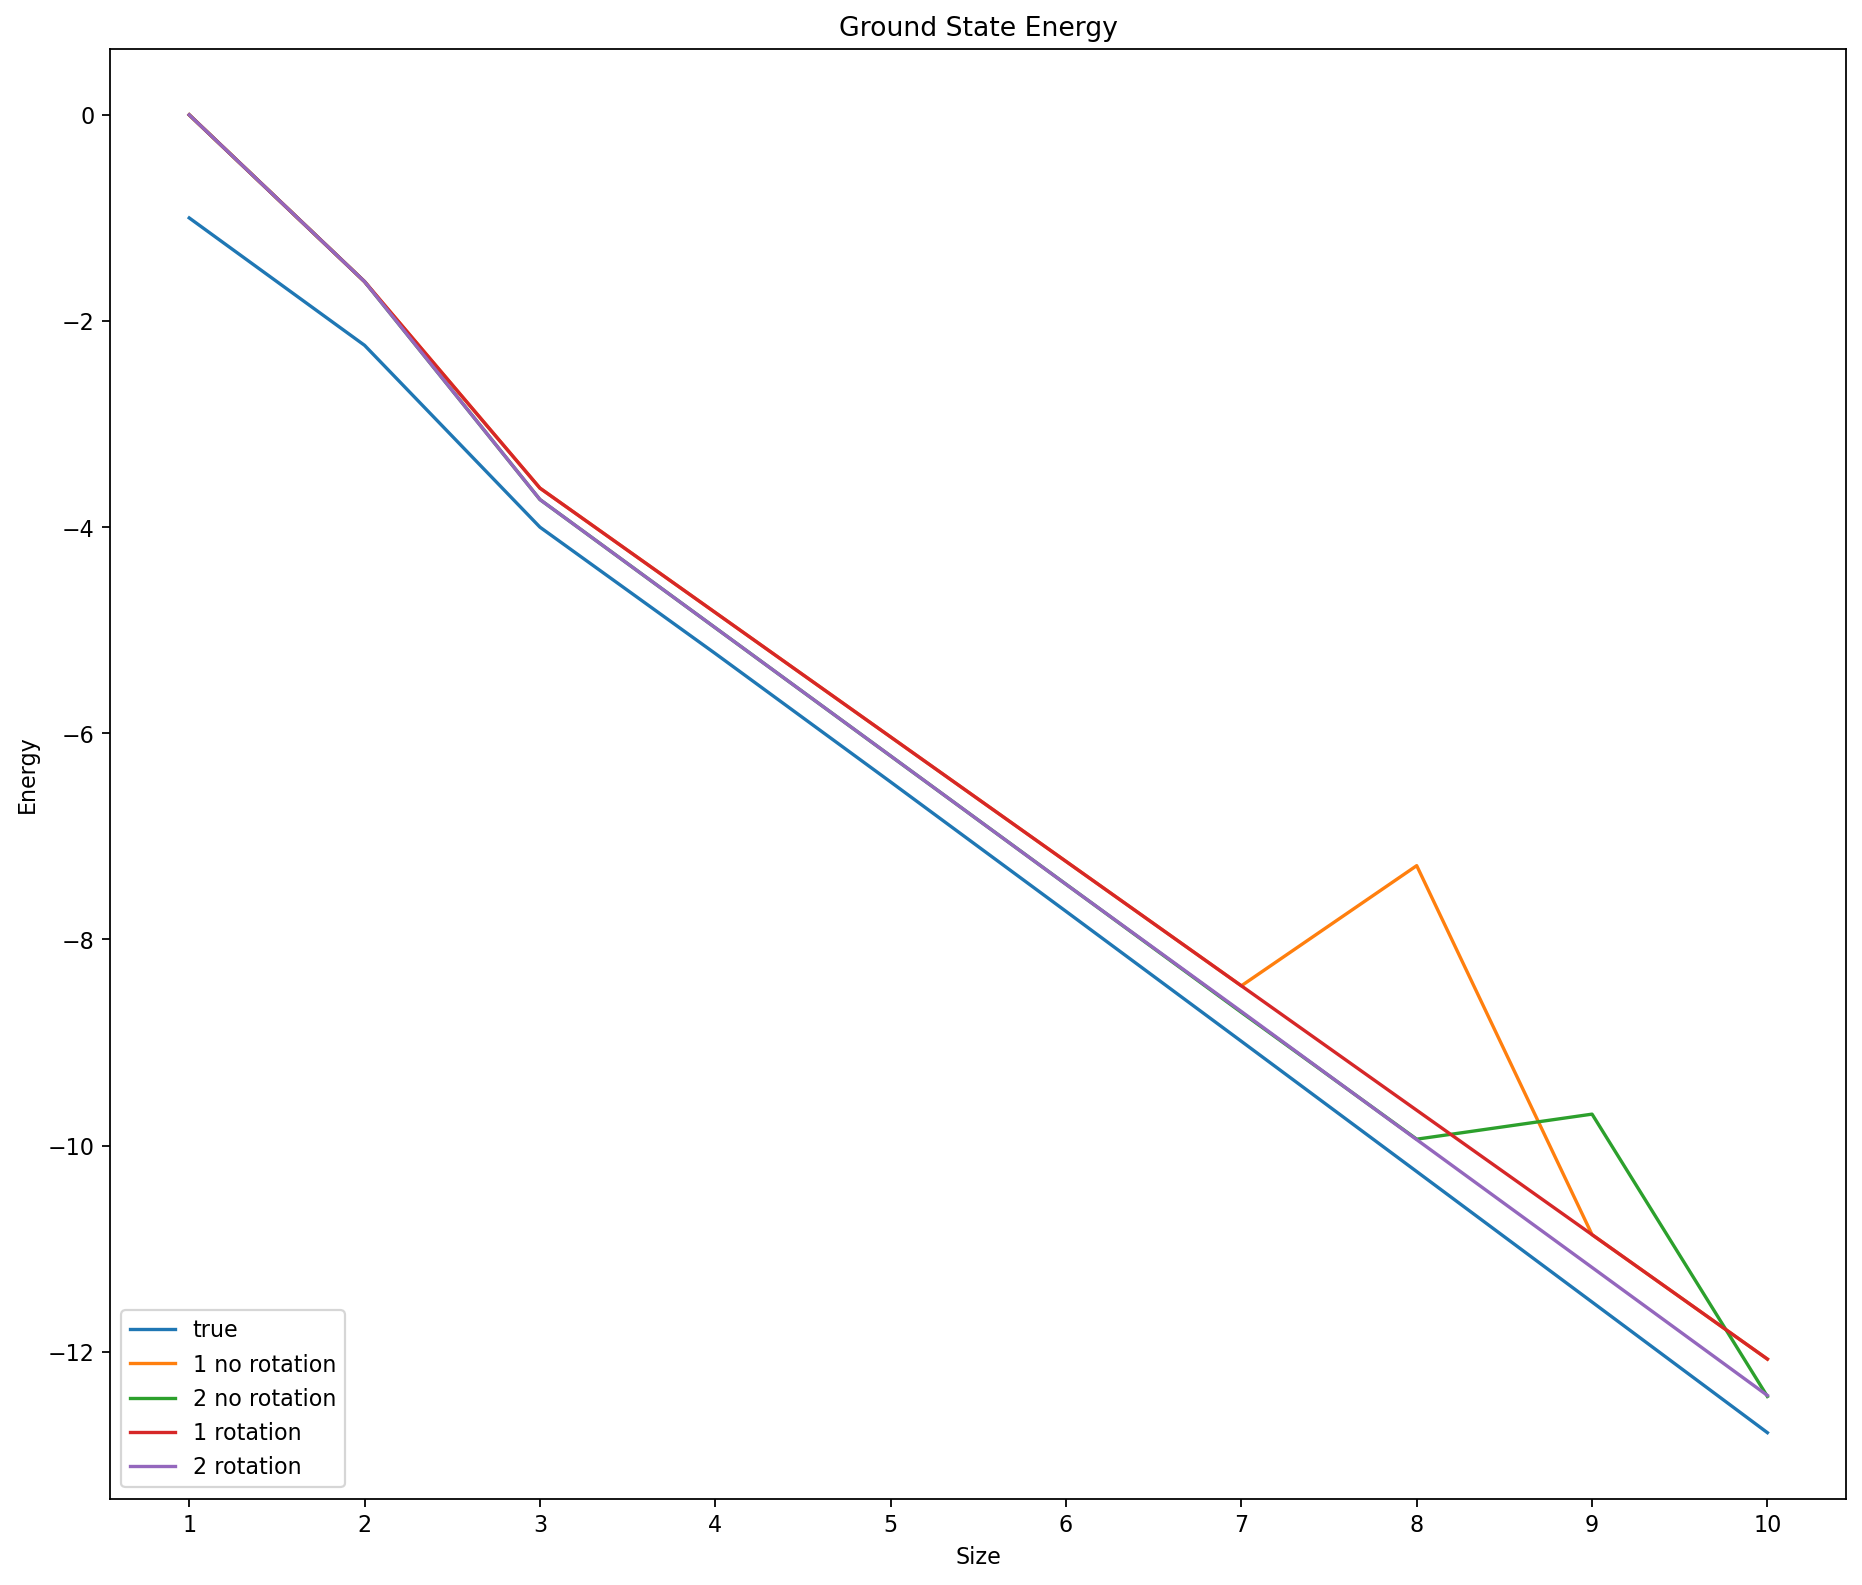

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, n)), np.real(trueGroundStates[1:]), label='true')
pylab.plot(list(range(1, n)), np.real(groundStatesNR[0][1:]), label='1 no rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesNR[1][1:]), label='2 no rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesR[0][1:]), label='1 rotation')
pylab.plot(list(range(1, n)), np.real(groundStatesR[1][1:]), label='2 rotation')

pylab.xlabel('Size')
pylab.xticks(list(range(1, n)))
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

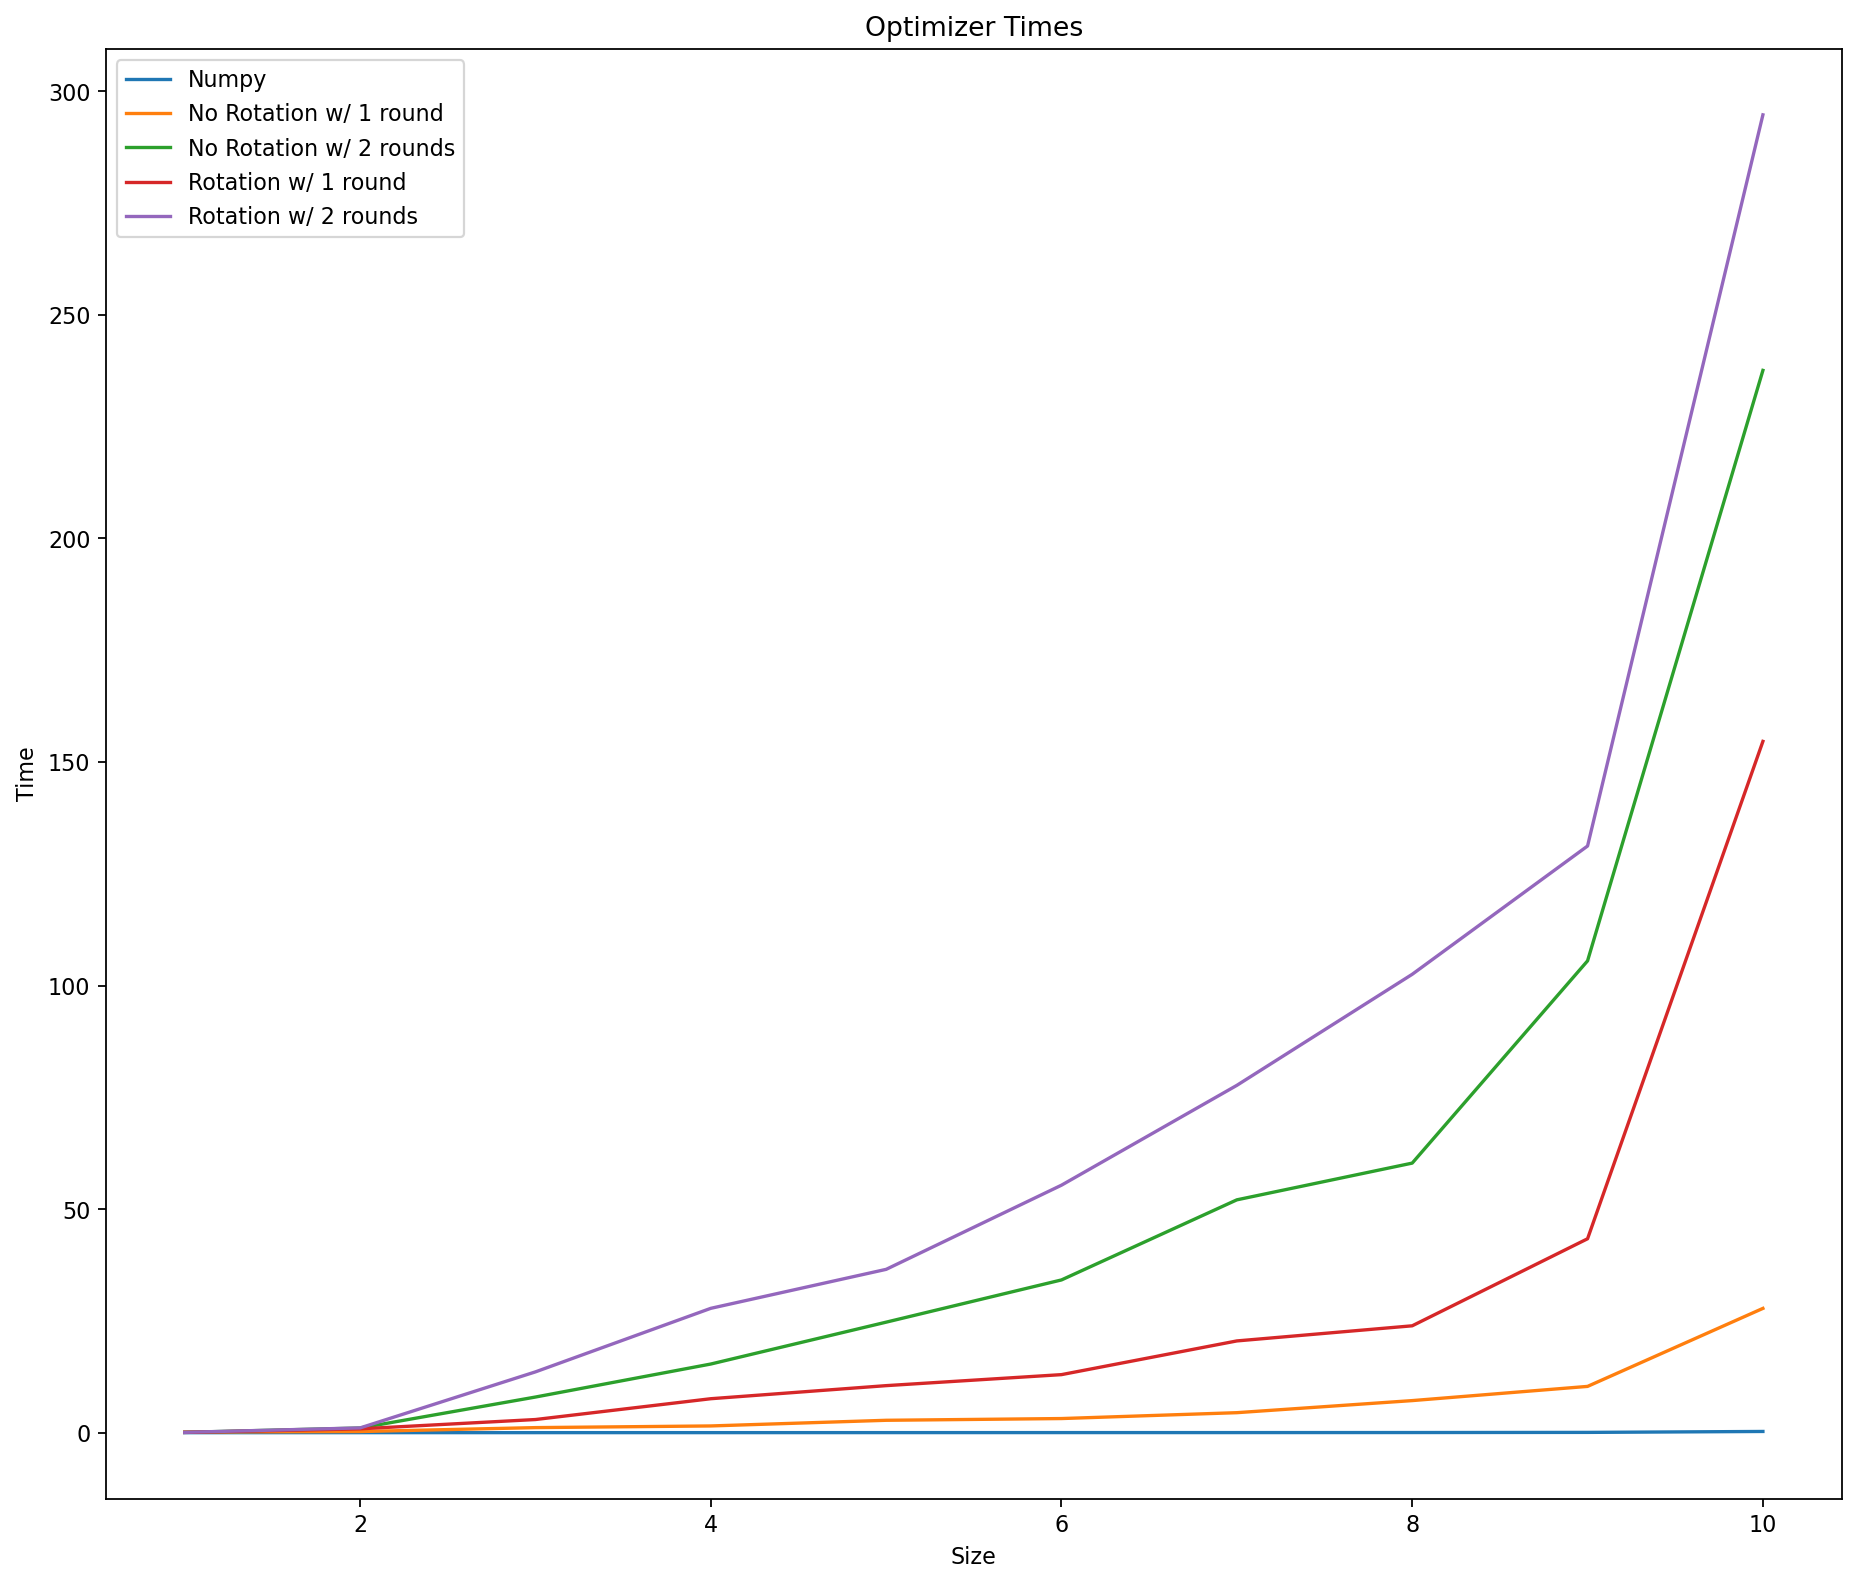

In [14]:
figure(figsize=(14, 12), dpi=160)

pylab.plot(list(range(1, n)),  trueTimes[1:], label='Numpy')
pylab.plot(list(range(1, n)),  np.sum(timesNR[0][1:], axis = 1), label='No Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesNR[1][1:], axis = 1), label='No Rotation w/ 2 rounds')
pylab.plot(list(range(1, n)),  np.sum(timesR[0][1:], axis = 1), label='Rotation w/ 1 round')
pylab.plot(list(range(1, n)),  np.sum(timesR[1][1:], axis = 1), label='Rotation w/ 2 rounds')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.title('Optimizer Times')
pylab.legend(loc='upper left')

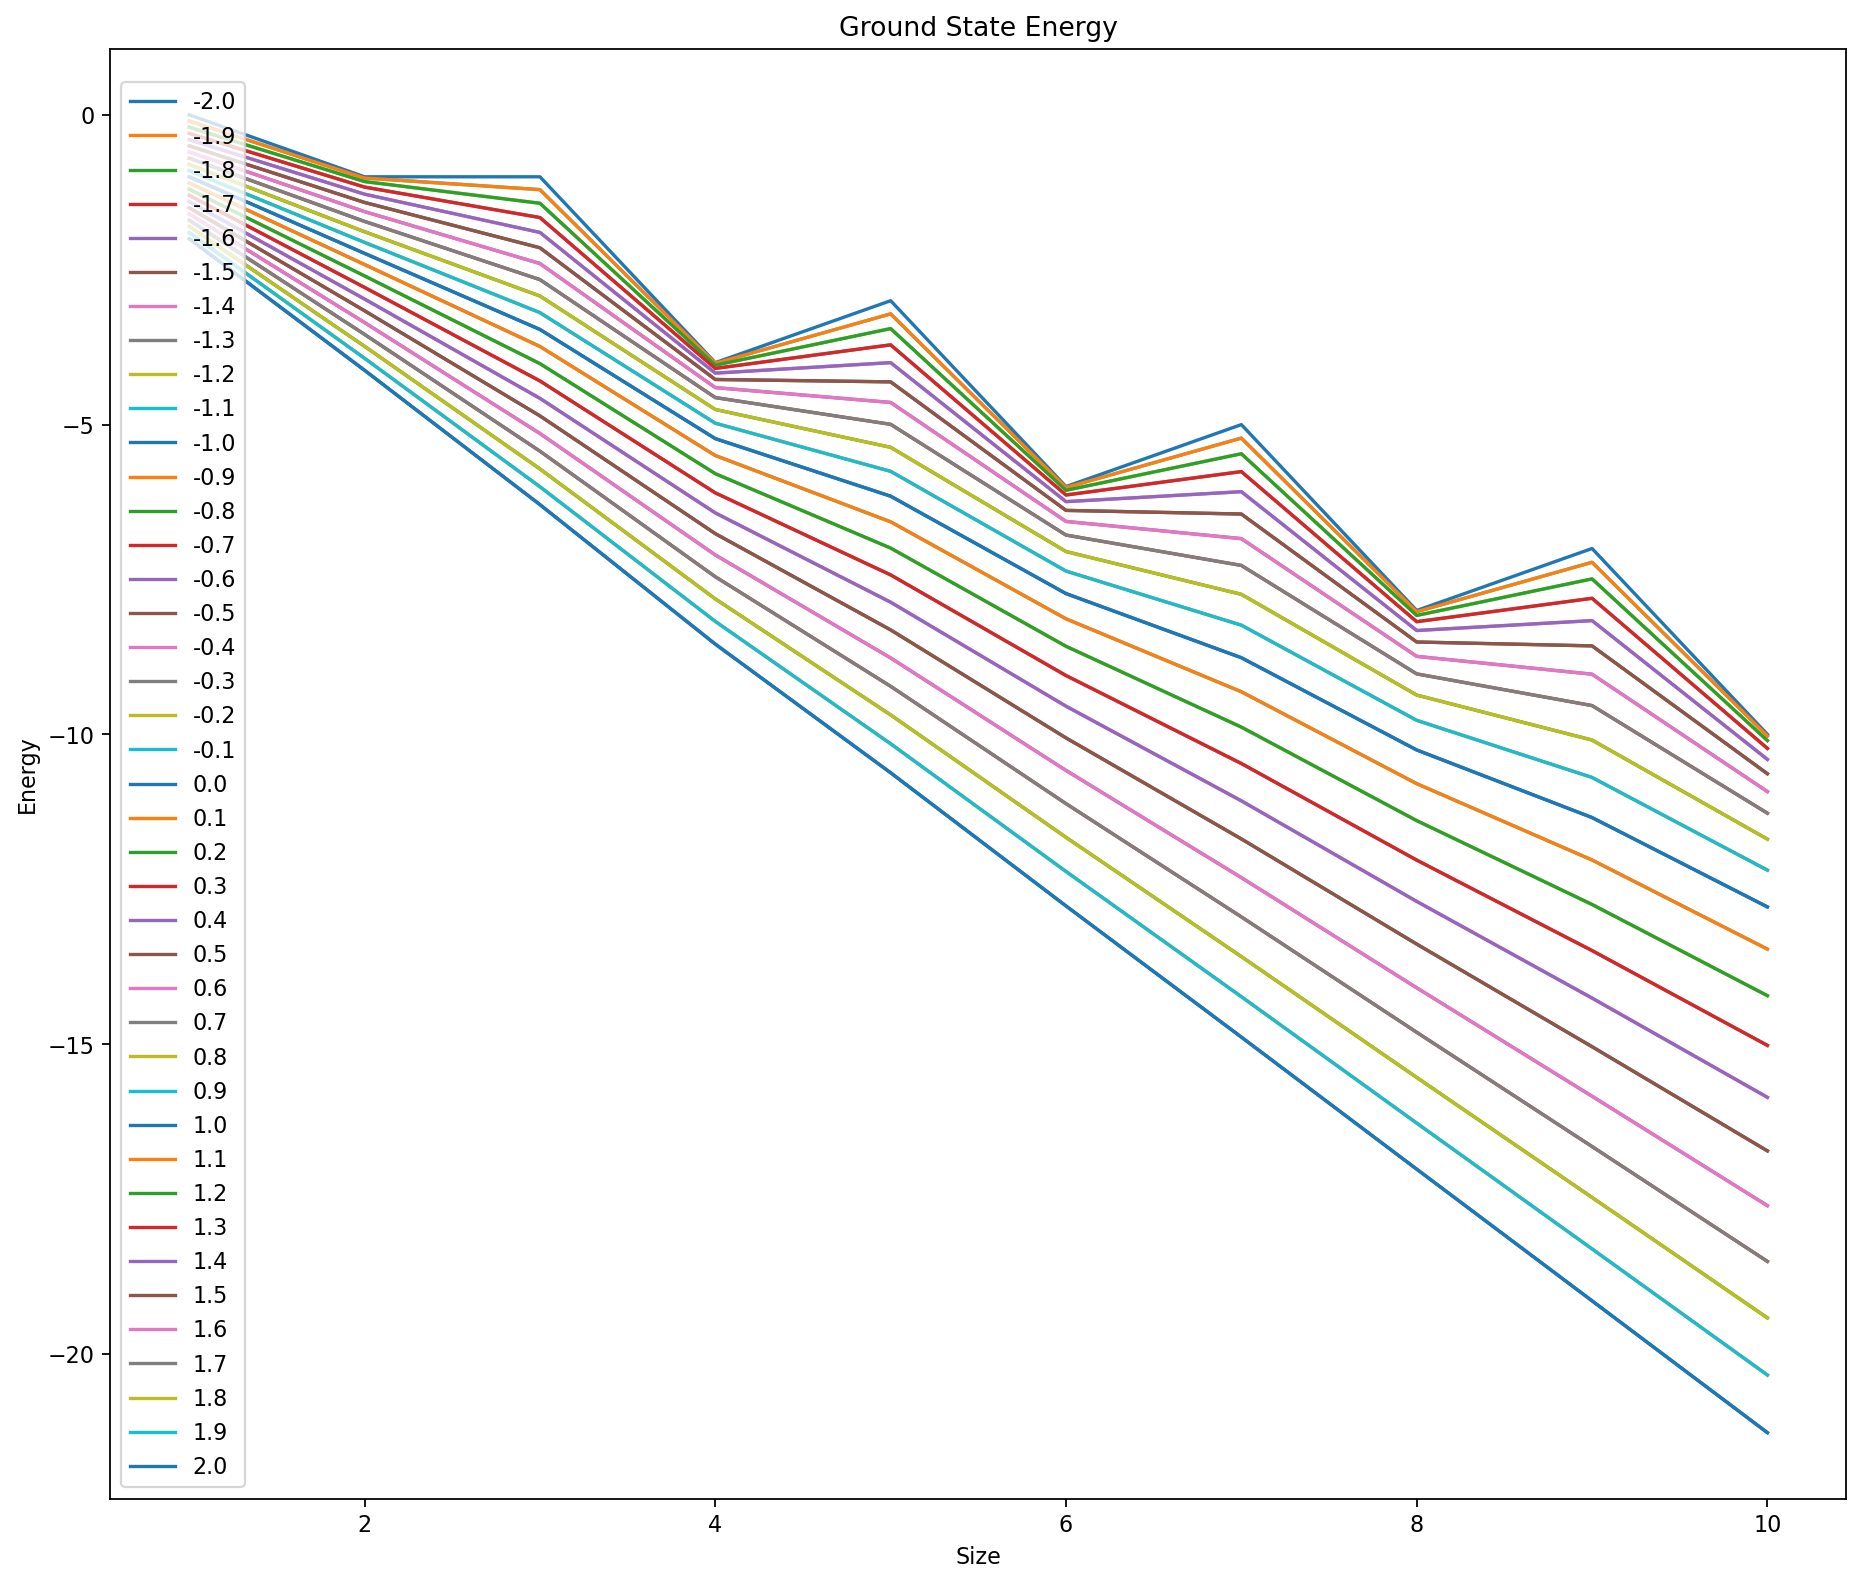

In [14]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

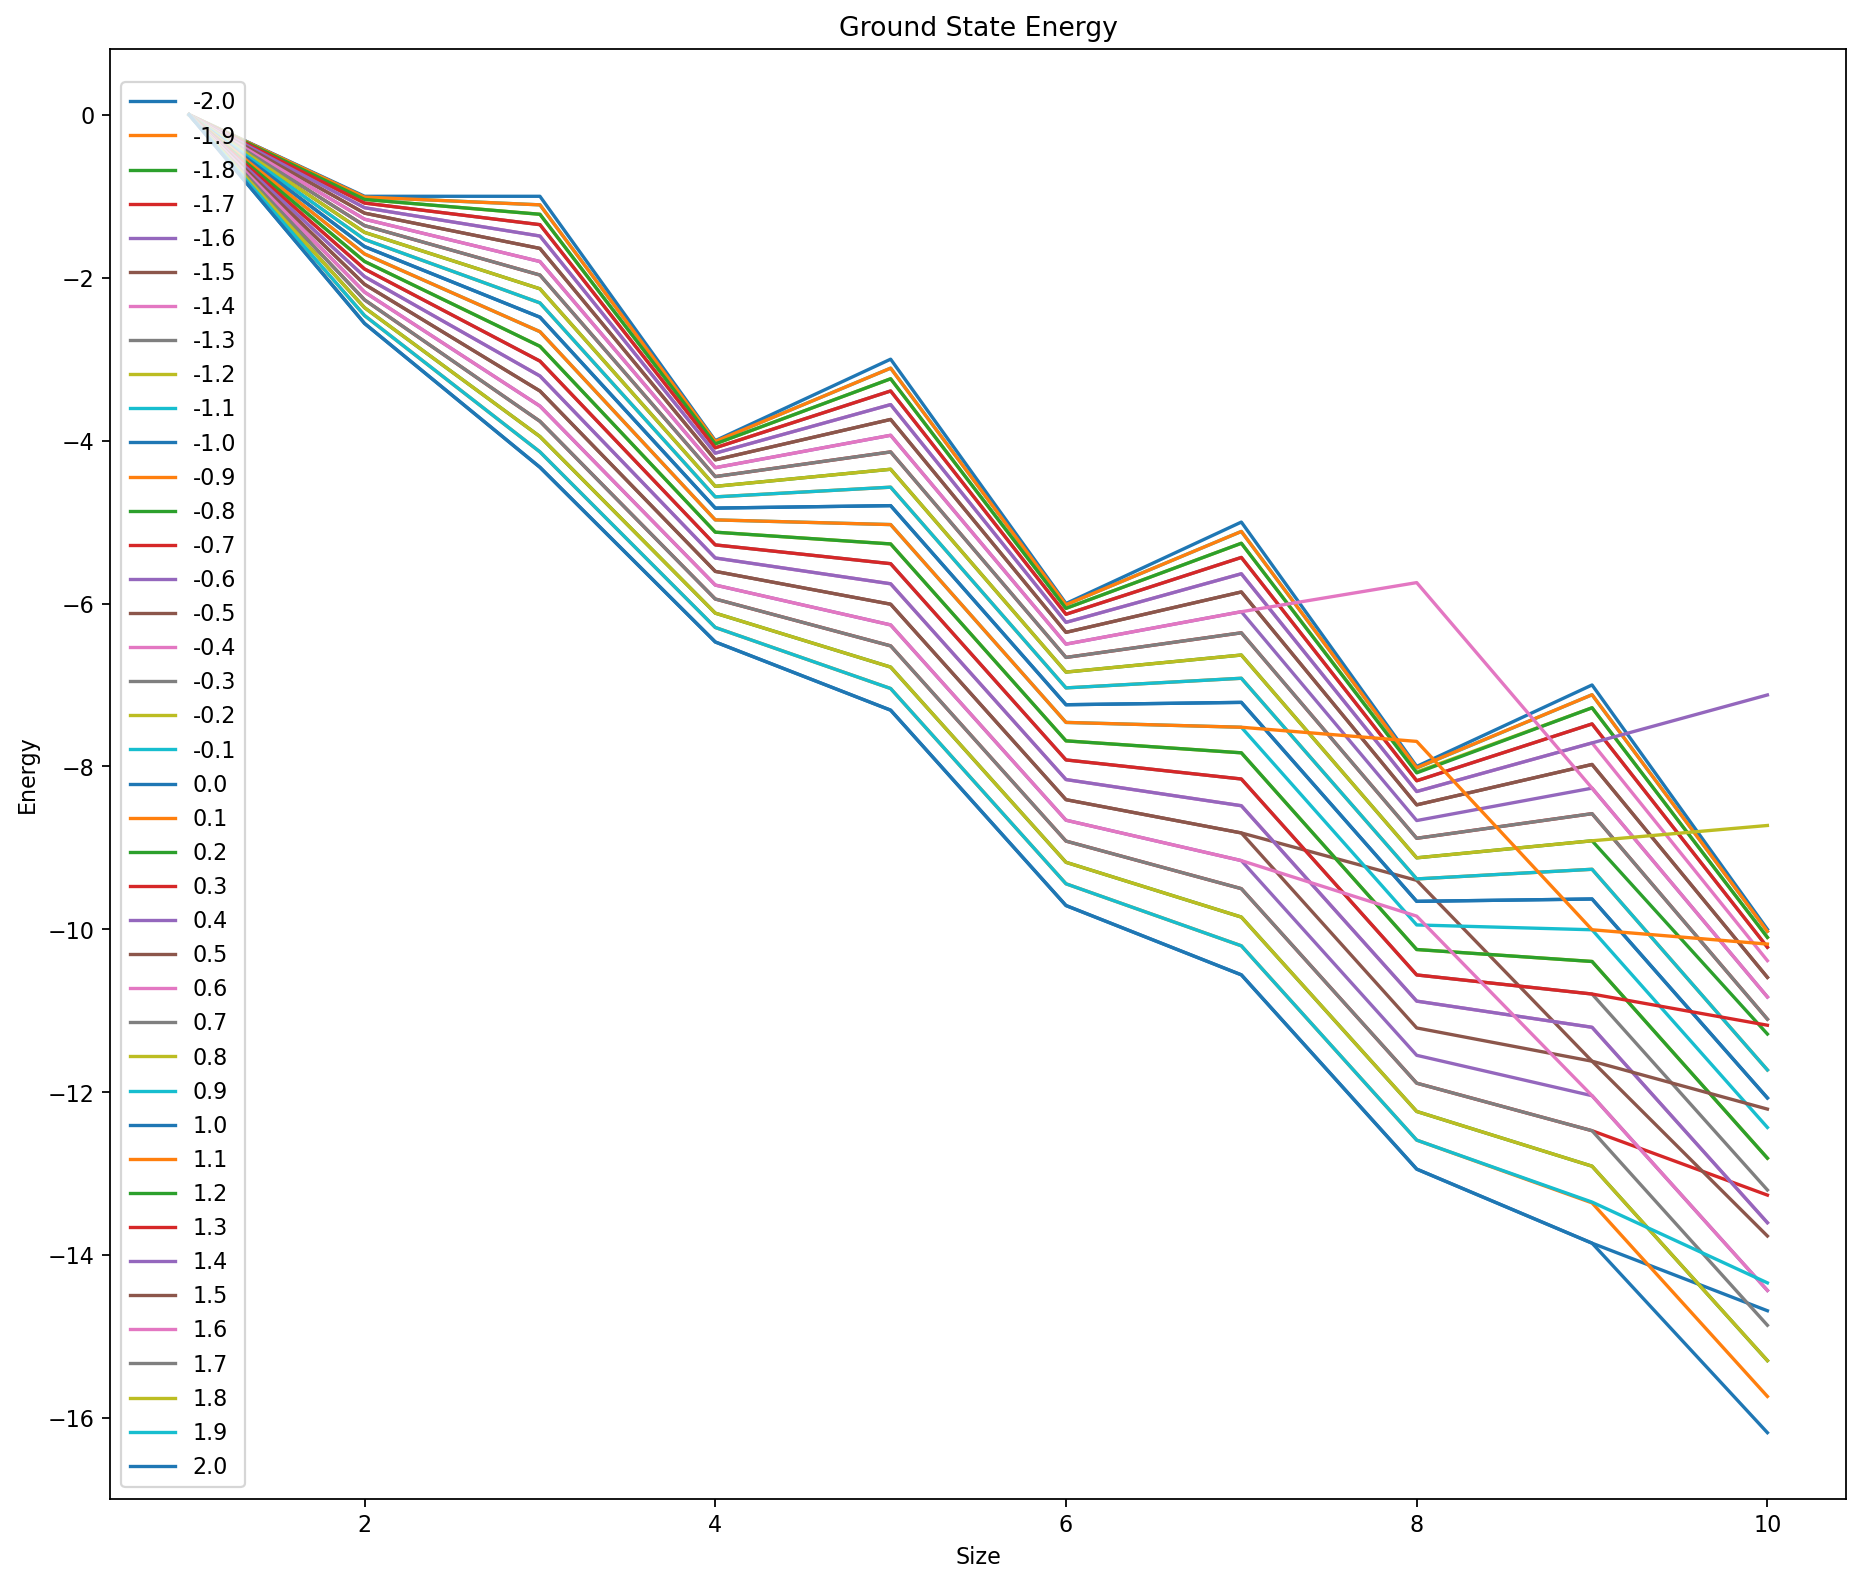

In [15]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

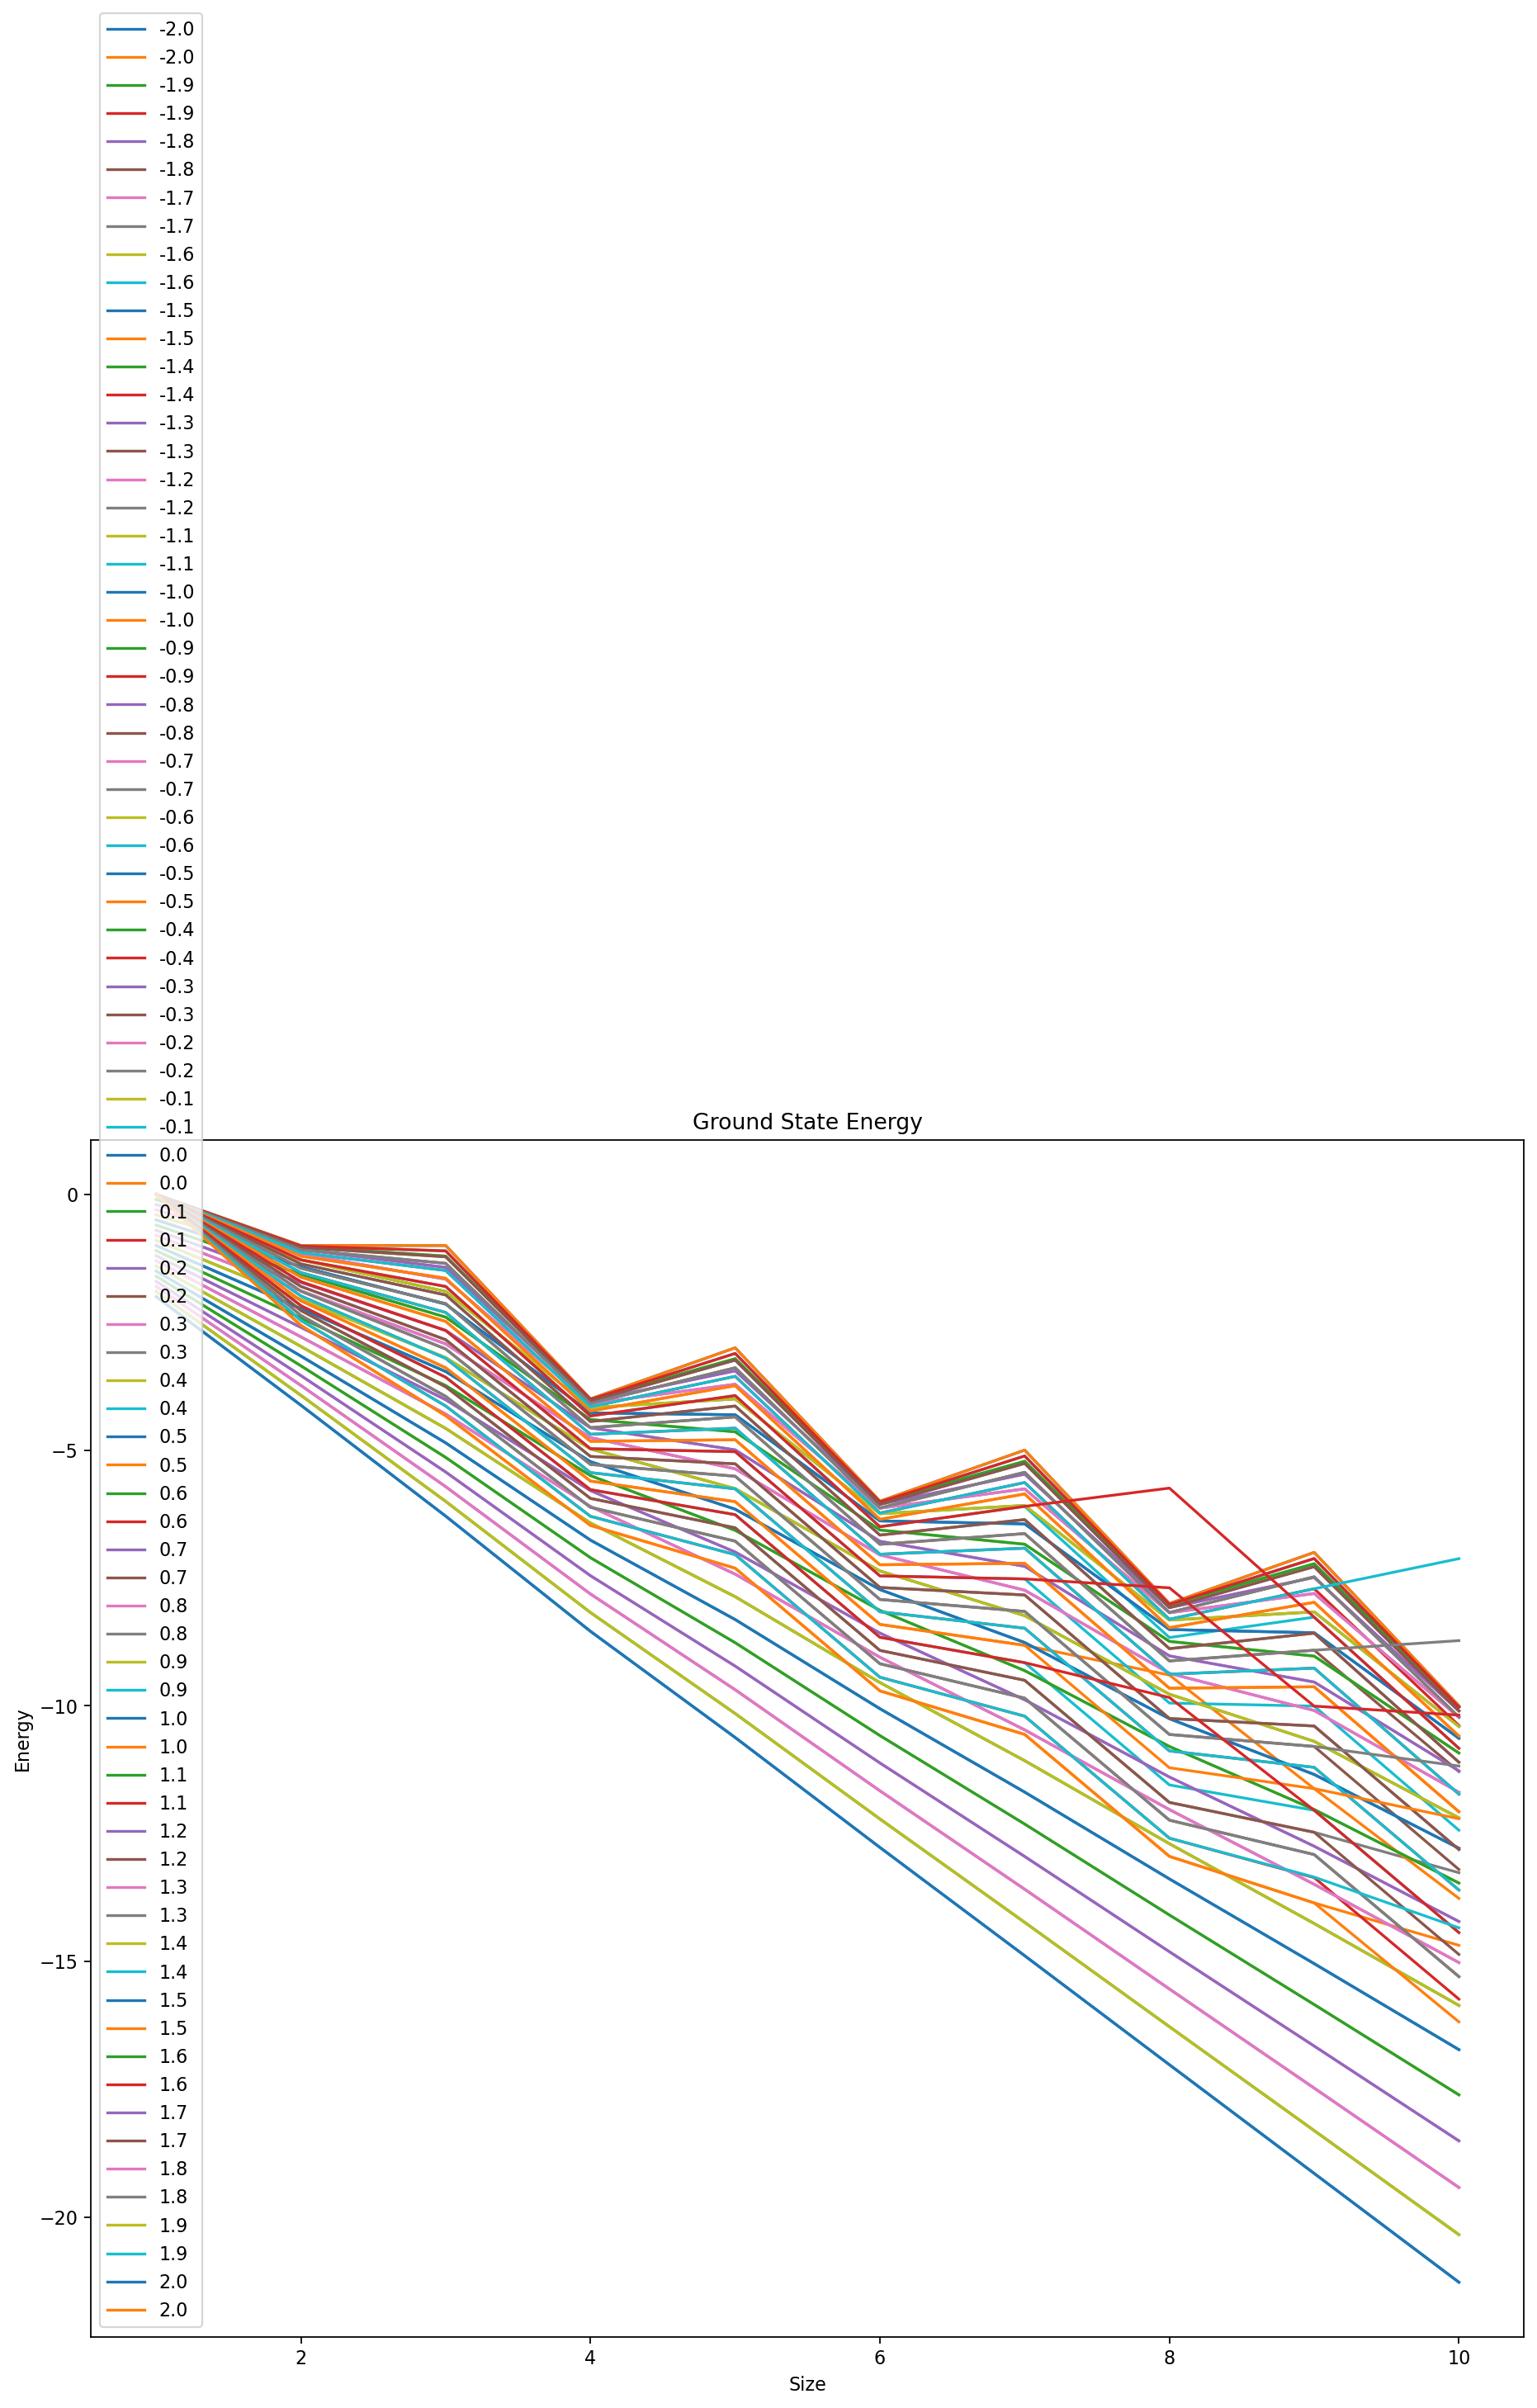

In [16]:
figure(figsize=(14, 12), dpi=160)

for i in range(s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

In [17]:
print(trueGroundStates)

[[  0.          -2.          -4.12310563  -6.29150262  -8.54311682
  -10.61988123 -12.76938913 -14.88646753 -17.01816447 -19.14311828
  -21.27120882]
 [  0.          -1.9         -3.92937654  -6.00294033  -8.17603546
  -10.1512486  -12.2129334  -14.23400591 -16.27432715 -18.3052991
  -20.34084655]
 [  0.          -1.8         -3.73630834  -5.71528229  -7.81322526
   -9.68578692 -11.66204633 -13.58685929 -15.53737341 -17.47470594
  -19.41884288]
 [  0.          -1.7         -3.54400903  -5.42863617  -7.45553236
   -9.22396432 -11.1179372  -12.94592945 -14.80875869 -16.65266279
  -18.50690039]
 [  0.          -1.6         -3.35261092  -5.14312668  -7.10401652
   -8.76633517 -10.58219668 -12.31231383 -14.09042044 -15.8408194
  -17.60727058]
 [  0.          -1.5         -3.16227766  -4.85889894  -6.76000855
   -8.31355733 -10.05694642 -11.68735103 -13.38500523 -15.04124236
  -16.72302491]
 [  0.          -1.4         -2.97321375  -4.5761226   -6.42517773
   -7.866412    -9.54504519 -11.072

In [18]:
print(groundStates)

[array([ 9.99990000e+03,  0.00000000e+00, -2.56155281e+00, -4.32727613e+00,
       -6.47213587e+00, -7.30950084e+00, -9.70820376e+00, -1.05590767e+01,
       -1.29442718e+01, -1.38538715e+01, -1.46833199e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.46468827e+00, -4.13823783e+00,
       -6.29418209e+00, -7.04379912e+00, -9.44127312e+00, -1.02027136e+01,
       -1.25883641e+01, -1.33591046e+01, -1.57354551e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.36815415e+00, -3.94995845e+00,
       -6.11825198e+00, -6.78058960e+00, -9.17737794e+00, -9.84991537e+00,
       -1.22365040e+01, -1.29085811e+01, -1.52956300e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.27200451e+00, -3.76252048e+00,
       -5.94461656e+00, -6.52010308e+00, -8.91692480e+00, -9.50106368e+00,
       -1.18892331e+01, -1.24730122e+01, -1.32635842e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.17630546e+00, -3.57601900e+00,
       -5.77359243e+00, -6.26259458e+00, -8.66038860e+00, -9.15658809e+00,
       -1

In [19]:
print(times)

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.32704973e-01, 8.78906250e-03, 8.17799568e-03, 8.79716873e-03,
        8.49008560e-03],
       [1.07452869e-01, 9.30333138e-02, 1.11892939e-01, 1.42736673e-01,
        7.02381134e-02],
       [2.87747860e-01, 2.69629955e-01, 3.89799833e-01, 1.65019035e-01,
        2.22244024e-01],
       [4.11638975e-01, 2.94414997e-01, 2.80057907e-01, 3.08272839e-01,
        4.09286976e-01],
       [4.79984999e-01, 7.36867189e-01, 6.21248007e-01, 3.96575928e-01,
        6.76591158e-01],
       [8.00769091e-01, 8.50059032e-01, 8.89765024e-01, 8.18988800e-01,
        1.13092899e+00],
       [1.37687707e+00, 1.00011992e+00, 2.14816999e+00, 1.40781903e+00,
        1.88543200e+00],
       [1.31545019e+00, 2.02985406e+00, 1.97590613e+00, 1.74905896e+00,
        3.01024675e+00],
       [3.08992195e+00, 3.06250978e+00, 4.38809013e+00, 2.48010921e+00,
        2.67842722e+00],
       [9.92760181e+00, 8.394